In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle

In [3]:
class PreProcessing:
    def __init__(self):
        self.train = None
        self.test = None
        self.train_labels = None

    def read_data(self, train_path:str, train_label_path:str, test_path:str):
        self.train = pd.read_csv(train_path)
        self.test = pd.read_csv(test_path)
        self.train_labels = pd.read_csv(train_label_path)
        #return mnist_train, mnist_test, mnist_train_labels

    def split_validation_set(self):
        """

        :return: a list of indexes , selected randomly, to be the validation set
        """

        grouped = self.train_labels.groupby('Class').agg('count').reset_index()
        valid_set = []
        for c in grouped['Class']:
            c_records = np.where(self.train_labels == c)[0]
            size = int(grouped['Index'][c]/5)
            balanced_random = np.random.choice(c_records, replace=False, size=size).tolist()
            valid_set = valid_set + balanced_random

        return valid_set

    def clean_data(self):
        """
        split train data into a train and validatoin set,
        normalize and standardize the data ( both in train and test),
        returns: 3 clean dataframes for train, validation and test set
        """
        cols  = []
        for col in self.train.columns:
            if len(self.train[col].unique()) == 1 and len(self.test[col].unique()) == 1:
                if self.train[col].unique()[0] == self.test[col].unique()[0]:
                    cols.append(col)
        print(cols)
        self.train.drop(columns=cols,axis=1,  inplace=True)
        self.test.drop(columns=cols,axis=1, inplace=True)

        # Normalize train set to mean 0 and standard deviation 1 feature-wise.
        # Apply the same transformation to the test set.
        train_mu = self.train.mean(axis=0)
        train_sigma  = self.train.std(axis=0)
        test_mu = self.test.mean(axis=0)
        test_sigma  = self.test.std(axis=0)
        normalized_train = (self.train - train_mu)/train_sigma
        normalized_test = (self.test - test_mu)/test_sigma

        # insert a column of 1s for the bias
        normalized_train['bias'] = 1
        normalized_test['bias'] = 1
        normalized_train = normalized_train.fillna(train_mu)
        normalized_test = normalized_test.fillna(test_mu)

        normalized_train = normalized_train.dropna(axis=1)
        normalized_test = normalized_test.dropna(axis=1)

        valid_indexes = self.split_validation_set()
        normalized_validation = normalized_train.filter(items=valid_indexes, axis = 0)
        normalized_train.drop(normalized_train.index[valid_indexes], inplace=True)
        y_valid = self.train_labels['Class'].filter(items=valid_indexes, axis = 0).sort_index()
        y_train = self.train_labels['Class'].drop(self.train_labels.index[valid_indexes]).sort_index()
        ohe = self.one_hot_encoding()
        y_onehot_valid = ohe[valid_indexes]
        y_onehot_train = np.delete(ohe,valid_indexes, axis=0)

        return normalized_train, normalized_validation, normalized_test, y_train, y_valid,y_onehot_train, y_onehot_valid

    def one_hot_encoding(self):
        records = self.train_labels['Class'].values
        print(type(records))
        unique_values = np.unique(records)
        ohe = np.zeros((records.shape[0],len(unique_values) ))

        for i in range(records.shape[0]):
            rec_class = self.train_labels['Class'][i]
            ohe[i, rec_class] +=1

        return ohe

In [19]:
class MinaLogisticRegression:
    def __init__(self, X, Y_onehot, Y_real):
        self.X = X
        self.Y_onehot = Y_onehot
        self.Y_real = Y_real
        self.W = np.zeros((X.shape[1], Y_onehot.shape[1]))
        self.loss = None
        self.error = None

    def softmax(self, z):
        """implement the softmax functions
        input: numpy ndarray
        output: numpy ndarray
        """
        exp_list = np.exp(z)
        result = 1/sum(exp_list) * exp_list
        result = result.reshape((len(z), 1))
        assert (result.shape == (len(z),1))
        return result

    def accuracy_error(self, pred):

        trues = np.where(pred - self.Y_real ==0)[0]
        falses = np.where(pred - self.Y_real !=0)[0]
        accuracy = len(trues)/(len(trues) + len(falses))
        error_rate = len(falses)/(len(trues) + len(falses))
        return accuracy, error_rate

    def loss_1(self):
        """
         Y: onehot encoded
        """
        Z = - self.X @ self.W
        N = self.X.shape[0]
        loss = 1/N * (np.trace(self.X @ self.W @ self.Y_onehot.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1))))
        return loss

    def loss_2(self):
        """
        Cross-Entropy
         Y: onehot encoded
        """
        Z = - self.X @ self.W
        return (1 / Z.shape[0]) * (self.Y_onehot * np.log(Z)).sum()

    def gradient(self, mu):
        Z = - self.X @ self.W
        P = []
        for z in Z:
            P.append(self.softmax(z))
        P= np.array(P).reshape((Z.shape[0], 19))
        #P = self.softmax(Z)
        N = self.X.shape[0]
        gd = 1/N * (self.X.T @ (self.Y_onehot - P)) + 2 * mu * self.W
        return gd

    def predict(self, Z):
        #Z = - self.X @ self.W
        P = []
        for z in Z:
            P.append(self.softmax(z))
        #P = self.softmax(Z)
        P = np.array(P).reshape((Z.shape[0], self.Y_onehot.shape[1]))
        return np.argmax(P, axis=1)

    def gradient_descent(self, max_iter=500, eta=0.1, mu=0.01):
        """
        Very basic gradient descent algorithm with fixed eta and mu
        """
        #W = np.zeros((X.shape[1], Y.shape[1]))
        step = 0
        steps = []
        losses = []
        W_lst = []
        errors = []
        accuracies = []
        while step < max_iter:
            step += 1
            print(step)
            self.W -= eta * self.gradient(mu)
            steps.append(step)
            W_lst.append(self.W)
            losses.append(self.loss_1())
            Z = -self.X @self.W
            accuracy, error = self.accuracy_error(self.predict(Z))
            print(error, accuracy)
            accuracies.append(accuracy)
            errors.append(error)

        df = pd.DataFrame({
            'step': steps,
            'loss': losses,
        })

        df2 = pd.DataFrame({
            'step': steps,
            'error': errors
        })
        return df, df2, self.W

    def fit(self):
        self.loss, self.error, self.W = self.gradient_descent()

    def loss_plot(self):
        return self.loss.plot(
            x='step',
            y='loss',
            xlabel='step',
            ylabel='loss'
        )
    def error_plot(self):
        return self.error.plot(
            x='step',
            y='error',
            xlabel='step',
            ylabel='error'
        )


In [26]:
class Evaluate:
    def __init__(self, models, validation, y_val, y_onehot_val):
        self.models = models
        self.val = validation
        self.Y_real = y_val
        self.Y_onehot = y_onehot_val

    def evaluate(self):
        eval = {}
        for model in self.models:
            Z = -self.val @ model.W
            pred = model.predict(Z)
            acc, err = model.accuracy_error(pred)
            name = model.__name__
            eval[name] = (acc, err)
        return eval

In [10]:
pp = PreProcessing()
pp.read_data(
    '../../kaggle_compatition_1/train.csv',
    '../../kaggle_compatition_1/train_result.csv',
    '../../kaggle_compatition_1/test.csv'
)
tr, val, te, yt, yv, yot, yov = pp.clean_data()

['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4', 'Feature 5', 'Feature 6', 'Feature 7', 'Feature 8', 'Feature 9', 'Feature 10', 'Feature 11', 'Feature 12', 'Feature 17', 'Feature 18', 'Feature 19', 'Feature 20', 'Feature 21', 'Feature 22', 'Feature 23', 'Feature 24', 'Feature 25', 'Feature 26', 'Feature 27', 'Feature 28', 'Feature 57', 'Feature 58', 'Feature 59', 'Feature 60', 'Feature 81', 'Feature 82', 'Feature 83', 'Feature 84', 'Feature 113', 'Feature 114', 'Feature 139', 'Feature 140', 'Feature 169', 'Feature 170', 'Feature 196', 'Feature 225', 'Feature 281', 'Feature 282', 'Feature 337', 'Feature 393', 'Feature 449', 'Feature 785', 'Feature 953', 'Feature 1121', 'Feature 1148', 'Feature 1289', 'Feature 1290', 'Feature 1316', 'Feature 1345', 'Feature 1346', 'Feature 1372', 'Feature 1401', 'Feature 1402', 'Feature 1428', 'Feature 1457', 'Feature 1458', 'Feature 1459', 'Feature 1483', 'Feature 1484', 'Feature 1513', 'Feature 1514', 'Feature 1515', 'Feature 1516', 'Feature 1537',

In [15]:
mlr = MinaLogisticRegression(tr.to_numpy(), yot, yt)

In [16]:
# 500 iter, learning_rate:0.1
mlr.fit()

1


/var/folders/pk/n0hgb2s14tn9kms7j58t522m0000gp/T/ipykernel_2534/3954494005.py:43: RuntimeWarning: invalid value encountered in log
  return (1 / Z.shape[0]) * (self.Y_onehot * np.log(Z)).sum(axis=1)


0.8427353845384788 0.15726461546152115
2
0.8390862056037391 0.16091379439626083
3
0.836211852333225 0.16378814766677496
4
0.8329125946662002 0.1670874053337999
5
0.8303131795346047 0.1696868204653953
6
0.82776375315554 0.17223624684445998
7
0.825489264915394 0.17451073508460596
8
0.8238146417056162 0.17618535829438375
9
0.8216401309705317 0.17835986902946838
10
0.8201904571471419 0.1798095428528581
11
0.8179659576595266 0.1820340423404734
12
0.8162413456972182 0.18375865430278188
13
0.8147166887450323 0.18528331125496764
14
0.813217026169112 0.18678297383088804
15
0.8117673523457222 0.18823264765427777
16
0.8099677572546177 0.1900322427453823
17
0.8087430328176161 0.19125696718238397
18
0.807493314004349 0.192506685995651
19
0.8059186682996325 0.19408133170036743
20
0.8045689719813042 0.1954310280186958
21
0.8030943037816491 0.19690569621835088
22
0.80131970306681 0.19868029693319003
23
0.7995700967282362 0.20042990327176385
24
0.7984953385488265 0.2015046614511735
25
0.797720512884601

<AxesSubplot:xlabel='step', ylabel='error'>

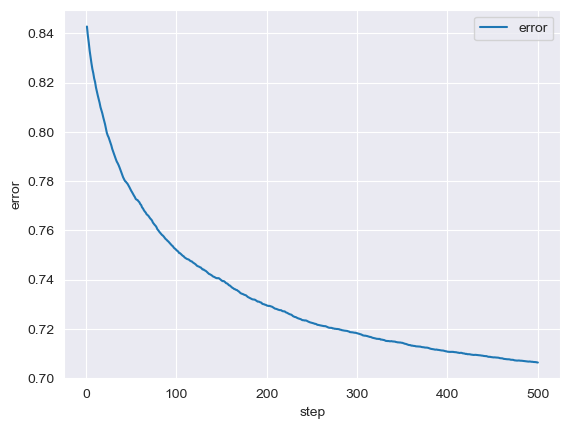

In [18]:
mlr.error_plot()

In [20]:
mlr2 = MinaLogisticRegression(tr.to_numpy(), yot, yt)
# 500 iter, learning_rate 0.1, mu=0.01, loss_2

In [21]:
mlr2.fit()

1
0.8427353845384788 0.15726461546152115
2
0.8390862056037391 0.16091379439626083
3
0.836211852333225 0.16378814766677496
4
0.8329125946662002 0.1670874053337999
5
0.8303131795346047 0.1696868204653953
6
0.82776375315554 0.17223624684445998
7
0.825489264915394 0.17451073508460596
8
0.8238146417056162 0.17618535829438375
9
0.8216401309705317 0.17835986902946838
10
0.8201904571471419 0.1798095428528581
11
0.8179659576595266 0.1820340423404734
12
0.8162413456972182 0.18375865430278188
13
0.8147166887450323 0.18528331125496764
14
0.813217026169112 0.18678297383088804
15
0.8117673523457222 0.18823264765427777
16
0.8099677572546177 0.1900322427453823
17
0.8087430328176161 0.19125696718238397
18
0.807493314004349 0.192506685995651
19
0.8059186682996325 0.19408133170036743
20
0.8045689719813042 0.1954310280186958
21
0.8030943037816491 0.19690569621835088
22
0.80131970306681 0.19868029693319003
23
0.7995700967282362 0.20042990327176385
24
0.7984953385488265 0.2015046614511735
25
0.7977205128846

<AxesSubplot:xlabel='step', ylabel='error'>

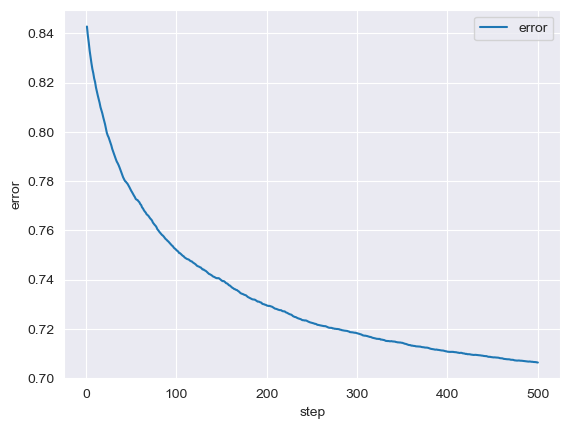

In [22]:
mlr2.error_plot()

<AxesSubplot:xlabel='step', ylabel='loss'>

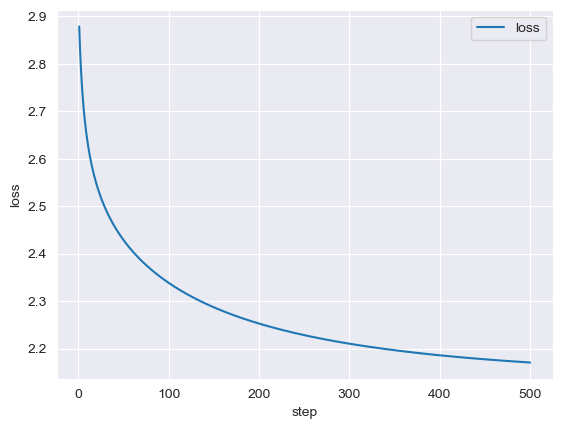

In [23]:
mlr2.loss_plot()